## Objective - Create a ML system that detects and classifies hand-written digits

#### Import modules and prepare dataset

In [15]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
%matplotlib inline

# Import other modules.
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pygame
from tkinter import *
from tkinter import messagebox
from time import time
from plyer import notification
from scipy.ndimage.interpolation import shift
from skimage.transform import rescale
from random import choice
import cv2
from IPython.display import clear_output

# NOTE: To import 'plyer' module, you must use 'pip install plyer'

# Import dataset.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# X represents the hand written digits which are 28 x 28 in size.
print(f'X_train.shape: {X_train.shape}')    # -> (60,000, 784)

# Y is the actual digits they represent.
print(f'y_train.shape: {y_train.shape}')    # -> (60,000,)

print(f'X_test.shape: {X_test.shape}')    # -> (10,000, 784)
print(f'y_test.shape: {y_test.shape}')    # -> (10,000,)


X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


#### Visualize the data using TSNE dimensionality technique

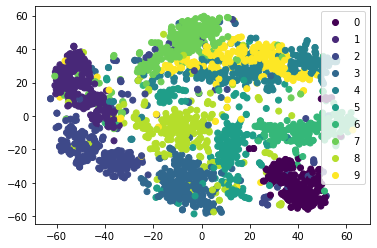

In [16]:
tsne = TSNE()

X_test_trans = tsne.fit_transform(X_test[:2500])

scatter = plt.scatter(X_test_trans[:, 0], X_test_trans[:, 1], c=y_test[:2500])
plt.legend(*scatter.legend_elements())
plt.show()

# Data is formed in clusters and looks to be linearly seperable.


#### Data analysis

In [17]:
data = np.concatenate((X_train, X_test))
target = np.concatenate((y_train, y_test))

# Check % of data that's 0.
percent_of_zeros = np.sum(data == 0)/data.size    # -> 80%
percent_of_non_zeros = np.sum(data != 0)/data.size    # -> 20%

# Check for null values.
check_null = np.isnan(np.sum(data))    # -> False

# Create scaler.
scaler = MinMaxScaler()

# Keep sample for comparison
sample = X_train[0]

# Reform the data.

print(X_train.shape)
print(X_test.shape)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Change to categorical data.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Change data to image data.
X_train = X_train.reshape((60000, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((10000, 28, 28, 1)).astype('float32')


(60000, 784)
(10000, 784)


#### Apply linear model to the data

In [19]:
perceptron = Perceptron(max_iter=99999999)    # Perceptron only works when data is linear.

# NOTE: Perceptron is a neural network with only one hidden-layer.

# Reform the data for Perceptron().
reform_sklearn = lambda target : np.array([np.argmax(sample) for sample in target])

perceptron_X_trian, perceptron_X_test = (X_train.reshape(60000, 784), X_test.reshape(10000, 784))
perceptron_y_train, perceptron_y_test = (reform_sklearn(y_train), reform_sklearn(y_test))

start_time = time()

perceptron.fit(perceptron_X_trian, perceptron_y_train)

print(f'Perceptron train score: {perceptron.score(perceptron_X_trian, perceptron_y_train)}')
print(f'Perceptron test score: {perceptron.score(perceptron_X_test, perceptron_y_test)}')
print(f'Iterations used: {perceptron.n_iter_}')
print(f'Elapsed: {(time() - start_time)/60:.2f} min.')


Perceptron train score: 0.9024666666666666
Perceptron test score: 0.8951
Iterations used: 24
Elapsed: 0.28 min.


#### Apply model to the data

In [20]:
def model():
    
    # Create model.
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
	
    # Compile model.
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# NOTE: Sequential() models allow you to make models layer-by-layer and is much simpler compared to Input() models.
#       Conv2D() is an input layer for converting an image in to a matrix.
#       MaxPooling2D() is another input layer.
#       Flatten() converts multi-dimensional data into a single vector to be processed. Ex: 28 x 28 -> 784
#       Dense() is the main hidden layer.
#       SGD() is stochastic gradient descent to update weights.

# Create timer.
start_time = time()

CNN = model()
CNN.fit(X_train, y_train, epochs=5, batch_size=128)

# Clear the output.
clear_output()

# NOTE: batch_size param means that the model will be tested on 64 samples at a time.
#       This save a ton of RAM.

print(train_score := 'CNN Train Score: {:.2f}'.format(CNN.evaluate(X_train, y_train, verbose=False)[1]*100))
print(test_score := 'CNN Test Score: {:.2f}'.format(CNN.evaluate(X_test, y_test, verbose=False)[1]*100))
print(elapsed := f'Elapsed: {(time() - start_time)/60:.2f} min.')

# Notify when done.
notification.notify(
    title='Neural Network Training Results',
    message=f'{train_score}\n{test_score}\n{elapsed}',
    app_icon='python_icon.ico'
)

CNN Train Score: 98.83
CNN Test Score: 98.20
Elapsed: 1.59 min.


#### Test the model through visualizations

4273


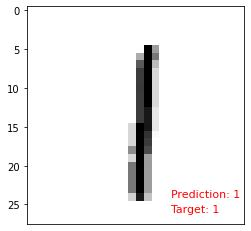

In [68]:
# Ask user for specific number to test model.
def pick_num():
    try:
        number = int(input('Choose a number to test the model on -> '))
    except ValueError:
        pick_num()
    else:
        return number

og_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])

index = choice(np.where(og_y_test == pick_num())[0])
sample = X_test[index].reshape(1, 28, 28, 1)
sample_target = og_y_test[index]

print(index)

prediction = np.argmax(CNN.predict(sample))

sample_img = sample.reshape(28, 28)

plt.imshow(sample_img, cmap='binary')
plt.text(18, 24, f'Prediction: {prediction}', fontsize=11, color='red')
plt.text(18, 26, f'Target: {sample_target}', fontsize=11, color='red')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
